<a href="https://colab.research.google.com/github/ZhuoChen-Work/OCDTD-Ensemble/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import mnist
import numpy as np
from scipy.spatial.distance import cdist
import random
from sklearn import svm
from scipy.spatial import distance
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from conv import ConvOCDTD
import utils

In [2]:
# preporcess for MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1,784)
x_test = x_test.reshape(-1,784)
x_train = x_train/255.
x_test = x_test/255.

index_train = [np.where(y_train==i) for i in range(10)]
index_test = [np.where(y_test==i) for i in range(10)]

# choose digit "2" as inliers, other digits are outliers 
train_inlier = x_train[index_train[2][0]]
train_outlier = x_train[np.where(y_train!=2)]

test_inlier = x_test[index_test[2][0]]
test_outlier = x_test[np.where(y_test!=2)]

# choose part of training sample to find optimal gamma value
#toy_data = np.concatenate([x_train[index_train[i][0]][:600] for i in range(10)])
#D_new_matrix = cdist(toy_data,toy_data)

#find best gamma and nu value for the OC-SVM model 
#best_gamma = utils.find_gamma(D_new_matrix)
#best_nu = utils.find_nu(train_inlier, test_inlier, test_outlier,best_gamma)

In [3]:
best_nu = 0.0037018690558462057
best_gamma = 1.2648552168552958

In [4]:
np.random.seed(123)
np.random.shuffle(test_outlier)
test_rest =test_outlier[:len(test_inlier)]

In [5]:
random.seed(66)
index1  = random.sample(range(len(train_inlier)),int(len(train_inlier/2)))
random.seed(123)
index2  = random.sample(range(len(train_inlier)),int(len(train_inlier/2)))

train_inlier1 = train_inlier[index1]
train_inlier2 = train_inlier[index2]

#build one-class SVM
clf1 = svm.OneClassSVM(nu=best_nu, kernel="rbf",gamma=best_gamma)
clf2 = svm.OneClassSVM(nu=best_nu, kernel="rbf",gamma=best_gamma)

In [6]:
# extract svm1
clf1.fit(train_inlier1)
dual_coef1 = clf1.dual_coef_.reshape(clf1.dual_coef_.shape[1],)
dual_sort1 = np.argsort(-dual_coef1)
m = 100
dual1 = dual_coef1[dual_sort1][:m]
support_vectors1 = clf1.support_vectors_[dual_sort1[:m],:]

# extract svm1
clf2.fit(train_inlier2)
dual_coef2 = clf2.dual_coef_.reshape(clf2.dual_coef_.shape[1],)
dual_sort2 = np.argsort(-dual_coef2)
n = 100
dual2 = dual_coef2[dual_sort2][:n]
support_vectors2 = clf2.support_vectors_[dual_sort2[:n],:]

In [7]:
def outlierness(X,svm,dual,gamma):
  dim = svm.shape[1]
  X=X.reshape(-1,dim)
  svm=svm.reshape(-1,dim)
  d=distance.cdist(X,svm,'sqeuclidean')
  return -np.log( (dual*np.exp(-gamma*d)).sum(axis=1) )

In [8]:
def get_auc_value(test_inlier,test_outlier,svm, dual, n_svm, gamma):
    dual_temp = dual[:n_svm]
    dual_temp = dual_temp/dual_temp.sum()
    value1 = -outlierness(test_inlier,svm[:n_svm,:],dual_temp,gamma)
    value2 = -outlierness(test_outlier,svm[:n_svm,:],dual_temp,gamma)
    value = np.concatenate((value1,value2),axis=0)
    label = np.concatenate( (np.ones(len(test_inlier)),np.zeros(len(test_outlier)) ),axis=0 )
    auc_value =  roc_auc_score(label,value) 

    return auc_value,value.max(),value.min()

In [9]:
get_auc_value(test_inlier,test_outlier,support_vectors1,dual1,100,best_gamma)

(0.894671147715564, -37.8843522330697, -161.11224723417735)

In [10]:
get_auc_value(test_inlier,test_outlier,support_vectors2,dual2,100,best_gamma)

(0.904772416481685, -29.57447229142181, -165.5804195100157)

In [11]:
def get_add_auc_value(test_inlier,test_outlier,svm1,svm2,dual1,dual2,n_svm,gamma):
    temp_sv1= svm1[:n_svm]
    temp_sv2= svm2[:n_svm]
    temp_dual1 = dual1[:n_svm]
    temp_dual2 = dual2[:n_svm]
    temp_dual1 = temp_dual1/temp_dual1.sum()
    temp_dual2 = temp_dual2/temp_dual2.sum()

    value1 = -outlierness(test_inlier,temp_sv1,temp_dual1,gamma)-outlierness(test_inlier,temp_sv2,temp_dual2,gamma)
    value2 = -outlierness(test_outlier,temp_sv1,temp_dual1,gamma)-outlierness(test_outlier,temp_sv2,temp_dual2,gamma)
    value = np.concatenate((value1,value2),axis=0)
    label = np.concatenate( (np.ones(len(test_inlier)),np.zeros(len(test_outlier)) ),axis=0 )
    auc_value =  roc_auc_score(label,value) 
    return auc_value,value.max()/2,value.min()/2

In [12]:
get_add_auc_value(test_inlier,test_outlier,support_vectors1,support_vectors2,dual1,dual2,100,best_gamma)

(0.9313221341686895, -37.8843522330739, -158.78004709771767)

In [13]:
def get_weighted_dual(sv1,sv2,d1,d2,best_gamma=best_gamma,alpha=0.1,normalization=1):
    support_matrix = sv2[np.newaxis,:,:]+sv1[:,np.newaxis,:]
    support_vector = support_matrix.reshape(-1,784)/2
    dual_matrix = np.log(d2)[np.newaxis,:]+np.log(d1)[:,np.newaxis]
    dual_matrix = np.exp(dual_matrix)
    dual = dual_matrix.reshape(-1,)

    dist_matrix = distance.cdist(sv1,sv2,metric="sqeuclidean")
    n = max( int(alpha*len(sv2)),1)

    index = np.argsort(dist_matrix)[:,n:]
    for i in range(len(sv1)):  
      dist_matrix[i][index[i]] = -1

    dist_matrix = dist_matrix.reshape(-1,) 
    support_vector = support_vector[dist_matrix>-0.5]
    dual = dual[dist_matrix>-0.5]

    bias_matrix = np.exp(-dist_matrix*best_gamma*0.5)
    bias = bias_matrix.reshape(-1,)[dist_matrix>-0.5]
    
    dual = dual*bias
    
    if normalization:
      dual = dual/dual.sum()
    return support_vector,dual

In [14]:
def get_times_auc_value(test_inlier,test_outlier,svm1,svm2,dual1,dual2,n_svm):
      temp_sv1= svm1[:n_svm]
      temp_sv2= svm2[:n_svm]
      temp_dual1 = dual1[:n_svm]
      temp_dual2 = dual2[:n_svm]
      temp_dual1 = temp_dual1/temp_dual1.sum()
      temp_dual2 = temp_dual2/temp_dual2.sum()

      sv1,d1 = get_weighted_dual(temp_sv1,temp_sv2,temp_dual1,temp_dual2)
      sv2,d2 = get_weighted_dual(temp_sv2,temp_sv1,temp_dual2,temp_dual1)

      value1 = -outlierness(test_inlier,sv1,d1,best_gamma*2)-outlierness(test_inlier,sv2,d2,best_gamma*2)
      value2 = -outlierness(test_outlier,sv1,d1,best_gamma*2)-outlierness(test_outlier,sv2,d2,best_gamma*2)
      value = np.concatenate((value1,value2),axis=0)
      label = np.concatenate( (np.ones(len(test_inlier)),np.zeros(len(test_outlier)) ),axis=0 )
      auc_value =  roc_auc_score(label,value) 
      return auc_value,value.max()/2,value.min()/2

In [15]:
get_times_auc_value(test_inlier,test_outlier,support_vectors1,support_vectors1,dual1,dual1,100)

(0.8944395966018713, -71.16353428016333, -317.9906554906926)

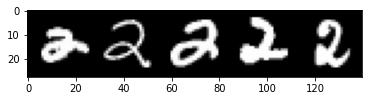

In [16]:
plt.imshow((support_vectors1[0:5,:]).reshape(1,5,28,28).transpose(0,2,1,3).reshape(1*28,5*28),cmap='gray')

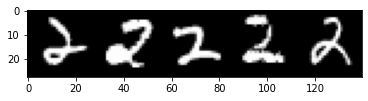

In [17]:
plt.imshow((support_vectors2[0:5,:]).reshape(1,5,28,28).transpose(0,2,1,3).reshape(1*28,5*28),cmap='gray')

In [18]:
class OCSVM():
  def __init__(self,q,sigma,alpha,svs):
    self.q = q
    self.sigma = sigma
    self.alpha = alpha
    self.svs = svs

class Net(nn.Module):
    def __init__(self,ocsvm):
        super(Net, self).__init__()
        self.myconv = ConvOCDTD(ocsvm,1)

    def forward(self,x):
        x = self.myconv(x)
        return x
    def explain(self,x):
        x = self.myconv.explain(x)
        return x

In [19]:
def get_R(support_vectors,dual,best_gamma,test_loader):
  ocsvm = OCSVM(2,np.sqrt(0.5/best_gamma),dual,support_vectors)
  net = Net(ocsvm)
  print(net)
  y_explain_=[]
  for i,x_batch in enumerate(test_loader):
    y_explain = net.explain(x_batch[0])
    y_explain_.append(y_explain)

  R=np.zeros([50,784])
  for i in range(50):
    R[i,:]=(y_explain_[i]).detach().numpy().reshape(-1,784)
    #R[i,:]=-R[i,:]

  return R

In [20]:
def get_mix_R(sv1,sv2,d1,d2,best_gamma,test_loader):
  temp_sv1,temp_d1 = get_weighted_dual(sv1,sv2,d1,d2)
  temp_sv2,temp_d2 = get_weighted_dual(sv2,sv1,d2,d1)

  temp_R1 = get_R(temp_sv1,temp_d1,2*best_gamma,test_loader)
  temp_R2 = get_R(temp_sv2,temp_d2,2*best_gamma,test_loader)

  return temp_R1+temp_R2

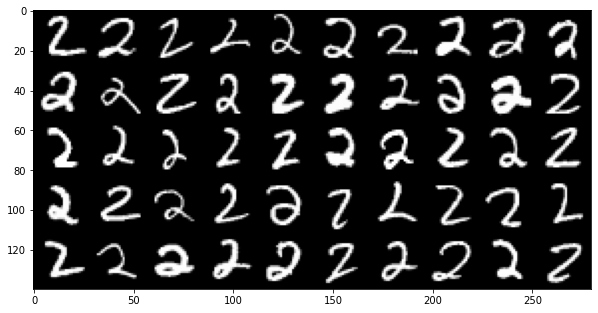

In [21]:
plt.figure(figsize=[10,20])
plt.imshow((test_inlier[:50]).reshape(5,10,28,28).transpose(0,2,1,3).reshape(5*28,10*28),cmap='gray')

In [22]:
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(test_inlier[:50]).reshape(50,1,28,28))
inlier_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)

In [23]:
support_vector_ub1,dual_ub1 = get_weighted_dual(support_vectors1,support_vectors1,
                    dual1,dual1,best_gamma=best_gamma,normalization=1)

support_vector_ub2,dual_ub2 = get_weighted_dual(support_vectors2,support_vectors2,
                    dual2,dual2,best_gamma=best_gamma,normalization=1)

In [24]:
R1_in = get_R(support_vectors1,dual1,best_gamma,inlier_loader)
R2_in = get_R(support_vectors2,dual2,best_gamma,inlier_loader)
R_all_in=(R1_in+R2_in)

R1_ub_in = get_R(support_vector_ub1,dual_ub1,2*best_gamma,inlier_loader)
R2_ub_in = get_R(support_vector_ub2,dual_ub2,2*best_gamma,inlier_loader)
R1xR2_ub_in = get_mix_R(support_vectors1,support_vectors2,dual1,dual2,best_gamma,inlier_loader)

Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 100, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)
Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 100, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)
Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 1000, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)
Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 1000, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)
Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 1000, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)
Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 1000, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)


In [25]:
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(test_outlier[:50]).reshape(50,1,28,28))
outlier_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)

In [26]:
R1_out = get_R(support_vectors1,dual1,best_gamma,outlier_loader)
R2_out = get_R(support_vectors2,dual2,best_gamma,outlier_loader)
R_all_out=(R1_out+R2_out)

R1_ub_out = get_R(support_vector_ub1,dual_ub1,2*best_gamma,outlier_loader)
R2_ub_out = get_R(support_vector_ub2,dual_ub2,2*best_gamma,outlier_loader)
R1xR2_ub_out = get_mix_R(support_vectors1,support_vectors2,dual1,dual2,best_gamma,outlier_loader)

Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 100, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)
Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 100, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)
Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 1000, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)
Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 1000, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)
Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 1000, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)
Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 1000, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)


In [27]:
def get_img_result(index_in,index_out,R_in,R_out,r=0.0):

    R_result_in = np.concatenate( [R_in[idx].reshape(1,-1) for idx in index_in ] )
    R_result_out = np.concatenate( [R_out[idx].reshape(1,-1) for idx in index_out ] )
    R_result = np.concatenate([R_result_in,R_result_out])
    R_result = (R_result-R_result.min())/(R_result.max()-R_result.min())

    R_result[R_result<r] = 0
    return R_result

In [28]:
index_in = [15,17,10,46]
index_out = [4,45,42,26]

In [29]:
R1_temp = get_img_result(index_in,index_out,R1_in,R2_out)
R2_temp = get_img_result(index_in,index_out,R2_in,R2_out)

R1_ub_temp = get_img_result(index_in,index_out,R1_ub_in,R1_ub_out)
R2_ub_temp = get_img_result(index_in,index_out,R2_ub_in,R2_ub_out)

R_all_temp = get_img_result(index_in,index_out,R_all_in,R_all_out)
R1xR2_ub_temp = get_img_result(index_in,index_out,R1xR2_ub_in,R1xR2_ub_out)

In [30]:
def get_imgdata(index_in,index_out):
    R1 = np.concatenate([test_inlier[idx].reshape(1,-1) for idx in index_in])
    R2 = np.concatenate([test_outlier[idx].reshape(1,-1) for idx in index_out])
    R_result = np.concatenate( [R1,R2] )

    return R_result

In [31]:
R_original = get_imgdata(index_in,index_out)

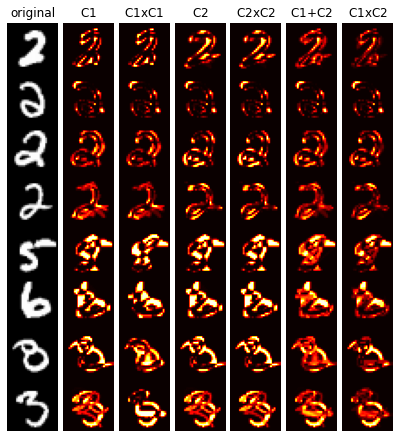

In [32]:
plt.figure(figsize=[7,7.5])

ax1 = plt.subplot(1,7,1)
ax1.set_title("original")
ax1.axis("off")
ax1.imshow(R_original.reshape(8,1,28,28).transpose(0,2,1,3).reshape(8*28,1*28),cmap='gray')

ax2 = plt.subplot(1,7,2)
ax2.axis("off")
ax2.set_title('C${1}$')
ax2.imshow(R1_temp.reshape(8,1,28,28).transpose(0,2,1,3).reshape(8*28,1*28),cmap='hot',vmax=1,vmin=0)

ax3 = plt.subplot(1,7,3)
ax3.axis("off")
ax3.set_title('C${1}$xC${1}$')
ax3.imshow(R1_ub_temp.reshape(8,1,28,28).transpose(0,2,1,3).reshape(8*28,1*28),cmap='hot',vmax=1,vmin=0)

ax4 = plt.subplot(1,7,4)
ax4.axis("off")
ax4.set_title('C${2}$')
ax4.imshow(R2_temp.reshape(8,1,28,28).transpose(0,2,1,3).reshape(8*28,1*28),cmap='hot',vmax=1,vmin=0)

ax5 = plt.subplot(1,7,5)
ax5.axis("off")
ax5.set_title('C${2}$xC${2}$')
ax5.imshow(R2_ub_temp.reshape(8,1,28,28).transpose(0,2,1,3).reshape(8*28,1*28),cmap='hot',vmax=1,vmin=0)

ax6 = plt.subplot(1,7,6)
ax6.axis("off")
ax6.set_title('C${1}$+C${2}$')
ax6.imshow(R_all_temp.reshape(8,1,28,28).transpose(0,2,1,3).reshape(8*28,1*28),cmap='hot',vmax=1,vmin=0)

ax7 = plt.subplot(1,7,7)
ax7.set_title('C${1}$xC${2}$')
ax7.axis("off")
ax7.imshow(R1xR2_ub_temp.reshape(8,1,28,28).transpose(0,2,1,3).reshape(8*28,1*28),cmap='hot',vmax=1,vmin=0)


plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("MNIST.pdf",bbox_inches="tight")